## **Homework-3: Multiclass semantic segmentation on road images**


* You will be using the dataset given as attachment (12 MB). Dataset has 265 images and same number of mask images (160x120 resolution). Mask images contain class ID for each pixel at the last (third) channel

In [1]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_names = glob.glob("/content/drive/MyDrive/Datasets/CameraRGB160x120/*")

In [4]:
#Resizing images, because UNet does not work without resizing
SIZE_X = 128
SIZE_Y = 128

In [5]:
#after sorting we will read  num_images  no of images
num_images = len(image_names)

image_names.sort()
images = [cv2.imread(image, 1) for image in image_names]
images = [cv2.resize(image, (SIZE_X, SIZE_Y)) for image in images]

image_dataset = np.array(images)

In [6]:
mask_names = glob.glob("/content/drive/MyDrive/Datasets/CameraMask160x120/*")
mask_names.sort()

masks = [cv2.imread(mask, 1)[:, :, 2] for mask in mask_names]
masks = [cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST) for mask in masks]

mask_dataset = np.array(masks)

In [7]:
n_classes = np.max(mask_dataset)

In [8]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))
print("Number of classes : ", n_classes)

Image data shape is:  (265, 128, 128, 3)
Mask data shape is:  (265, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Number of classes :  22


In [9]:
# Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# after label encoding
print("Now the labels in the mask are : ", np.unique(mask_dataset_encoded))

Now the labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [11]:
# to match the size of the mask dataset with image dataset
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(265, 128, 128, 1)


In [12]:
# Normalize images
image_dataset = image_dataset / 255.

In [13]:
# Split training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [14]:
from tensorflow.keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_train_cat.shape)
print(y_test_cat.shape)

(212, 128, 128, 22)
(53, 128, 128, 22)


In [15]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

# Batch normalization can be used within a UNet to facilitate faster and more stable
# learning by normalizing activations at each layer, which helps maintain consistent gradients.
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Decoder block
# skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # activation is softmax based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(128, 128, 3)


In [17]:
model = build_unet(input_shape, n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalizat

In [18]:
# Training the model using the training data (X_train, y_train_cat)
# - batch_size: 16, meaning the model will update weights after processing every 16 samples
# - verbose: 1, to print progress updates during training
# - epochs: 50, the model will iterate over the entire training dataset 50 times
# - validation_data: (X_test, y_test_cat), using test data for validation after each epoch
# - shuffle: False, the training data will not be shuffled before each epoch

history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=60,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/60
14/14 [==============================] - 52s 1s/step - loss: 1.3963 - accuracy: 0.7078 - val_loss: 5.3068 - val_accuracy: 0.1334
Epoch 2/60
14/14 [==============================] - 3s 238ms/step - loss: 0.6348 - accuracy: 0.8619 - val_loss: 22.1395 - val_accuracy: 0.0897
Epoch 3/60
14/14 [==============================] - 3s 240ms/step - loss: 0.5018 - accuracy: 0.8768 - val_loss: 5.9818 - val_accuracy: 0.1909
Epoch 4/60
14/14 [==============================] - 3s 238ms/step - loss: 0.4598 - accuracy: 0.8810 - val_loss: 1.9588 - val_accuracy: 0.6079
Epoch 5/60
14/14 [==============================] - 3s 246ms/step - loss: 0.4048 - accuracy: 0.8898 - val_loss: 1.5294 - val_accuracy: 0.6917
Epoch 6/60
14/14 [==============================] - 3s 237ms/step - loss: 0.3594 - accuracy: 0.9007 - val_loss: 2.0818 - val_accuracy: 0.6027
Epoch 7/60
14/14 [==============================] - 3s 239ms/step - loss: 0.3313 - accuracy: 0.9054 - val_loss: 1.8841 - val_accuracy: 0.6421
Epoch 8

In [19]:
# Save the model for future use because 60 epochs takes long time to retrain for testing
# model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/multiclass_ss.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Load previously saved model (Optional)
# from keras.models import load_model
# model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/multiclass_ss.hdf5", compile=False)

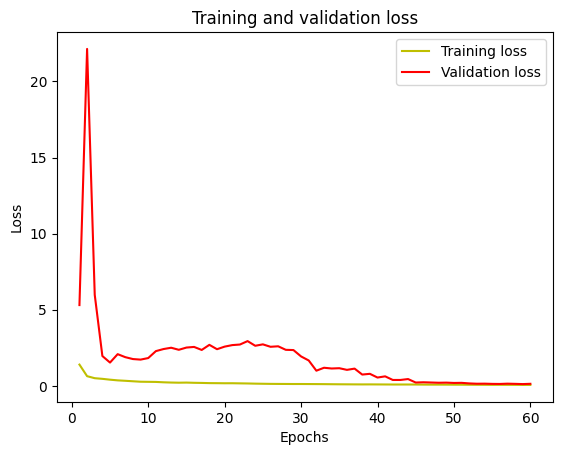

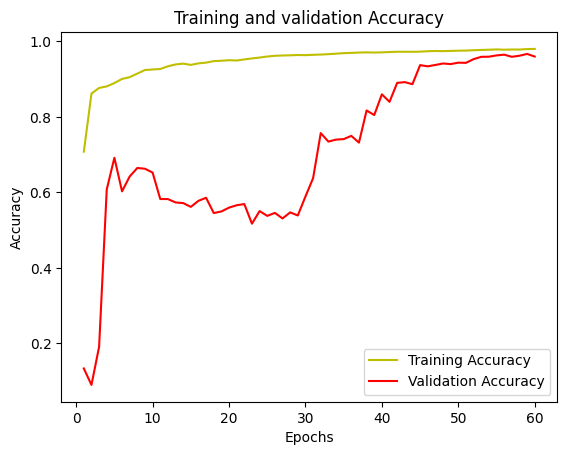

In [21]:
# plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
y_pred=model.predict(X_test)
y_pred.shape

2/2 [==============================] - 15s 6s/step


(53, 128, 128, 22)

In [23]:
# line below selects the highest score class for every pixel and writes it to one matrix (y_pred_argmax)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(53, 128, 128)

In [24]:
print(y_pred_argmax[0,0:5,0:5])

[[12 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]]


In [25]:
# Using built in keras function
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5308814


In [26]:
import numpy as np

# To calculate IOU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

# Calculate IoU for each class
iou_per_class = []
for i in range(n_classes):
    intersection = values[i, i]
    union = np.sum(values[i, :]) + np.sum(values[:, i]) - intersection
    iou = intersection / union if union != 0 else 0
    iou_per_class.append(iou)
    print(f"IoU for class {i+1} is: {iou}")

# Optionally, you can print all IoUs at once
print("IoUs for all classes: ", iou_per_class)


[[4.99540e+04 4.31000e+02 0.00000e+00 0.00000e+00 2.68000e+02 1.00000e+00
  1.30000e+01 6.10000e+01 1.34500e+03 7.00000e+01 7.22000e+02 0.00000e+00
  9.11000e+02 0.00000e+00 0.00000e+00 2.40000e+01 1.50000e+01 0.00000e+00
  1.70000e+01 2.40000e+01 0.00000e+00 8.60000e+02]
 [1.90000e+01 2.05800e+03 0.00000e+00 0.00000e+00 5.00000e+00 7.30000e+01
  8.30000e+01 9.00000e+01 2.04000e+02 1.50000e+01 1.50000e+01 0.00000e+00
  3.10000e+01 0.00000e+00 1.20000e+01 1.00000e+00 7.00000e+01 1.00000e+00
  2.00000e+00 0.00000e+00 0.00000e+00 2.63000e+02]
 [2.80000e+01 0.00000e+00 1.60000e+01 0.00000e+00 7.00000e+00 0.00000e+00
  0.00000e+00 5.10000e+01 1.65000e+02 0.00000e+00 0.00000e+00 0.00000e+00
  2.43000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.30000e+01]
 [3.00000e+00 1.10000e+01 0.00000e+00 1.00000e+00 1.10000e+01 0.00000e+00
  7.00000e+00 1.20000e+01 3.40000e+01 4.30000e+01 3.80000e+01 0.00000e+00
  2.00000e+00 0.00000e+00 7.00000

1/1 [==============================] - 2s 2s/step


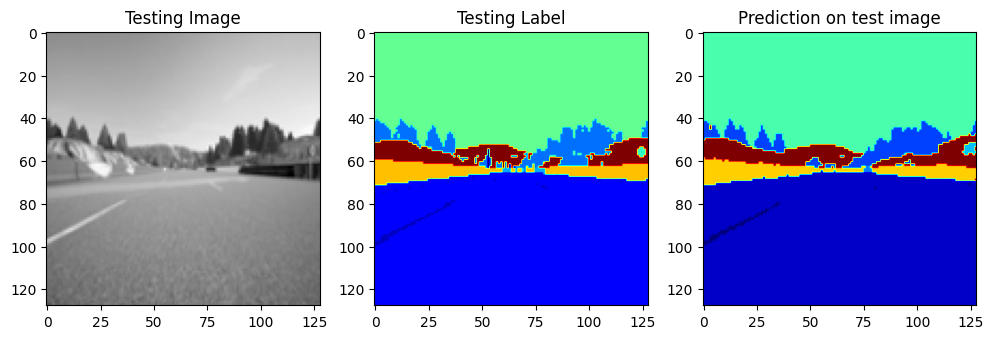

In [27]:
import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

# Results  ☕
Based on the results of our UNet model experiment for masked and RGB images, we can draw several encouraging conclusions:

### Training and Validation Accuracy
- **Training Accuracy**: The yellow line representing training accuracy shows a consistent upward trend, quickly reaching a high value close to 1.0 and remaining stable. This indicates that our model has effectively learned the features of the training dataset.
- **Validation Accuracy**: The red line for validation accuracy exhibits some fluctuations in the early epochs, which is expected as the model adjusts its parameters. However, it steadily improves over time and stabilizes at a high accuracy level. This progression is a strong indicator that the model is effectively generalizing from the training data to unseen validation data.

### Training and Validation Loss
- **Training Loss**: The training loss starts low and remains low and stable throughout the training process. This is consistent with the high training accuracy and confirms that the model is fitting the training data well.
- **Validation Loss**: Initially, the validation loss is quite high, but it dramatically decreases within the first few epochs and then stabilizes.

### Conclusion
- **Model Performance**: The high final validation accuracy and the low validation loss suggest that the model is performing well.

Overall, these results are promising and demonstrate the success of our UNet model in accurately learning and generalizing the task of image segmentation. The high final accuracy and low loss metrics validate the effectiveness of our approach.

The Mean IoU score of 0.53 reflects a successful initial training of the UNet model on masked and RGB images. The model has demonstrated its capability to learn and generalize the segmentation task effectively.

### MUHAMMED EFE İNCİR 